# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [10]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models
from tensorflow.contrib.keras.python.keras.utils import plot_model

import pydot

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [11]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [12]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [13]:
def encoder_block(input_layer, filters, strides):
    
    #Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides=strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [14]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # Upsample the small input layer using the bilinear_upsample() function.
    upsampled_layer = bilinear_upsample(small_ip_layer)
    
    # Concatenate the upsampled and large input layers using layers.concatenate
    skip_connect = layers.concatenate([upsampled_layer, large_ip_layer])
    
    # Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(skip_connect, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [15]:
def fcn_model(inputs, num_classes):
    
    filters = 32
    strides = 2
    
    # Add Encoder Blocks. 
    layer1 = encoder_block(inputs, filters, strides=strides)
    layer2 = encoder_block(layer1, filters * 2, strides=strides)

    # Add 1x1 Convolution layer using conv2d_batchnorm().
    layer3 = conv2d_batchnorm(layer2, filters * 4, kernel_size=1, strides=1)
    
    # Add the same number of Decoder Blocks as the number of Encoder Blocks
    layer4 = decoder_block(layer3, layer1, filters * 2)
    layer5 = decoder_block(layer4, inputs, filters)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(layer5)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [16]:
image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [17]:
learning_rate = 0.002
batch_size = 50
num_epochs = 100
steps_per_epoch = 200
validation_steps = 50
workers = 2

Epoch 1/100
199/200 [============================>.] - ETA: 0s - loss: 0.3089

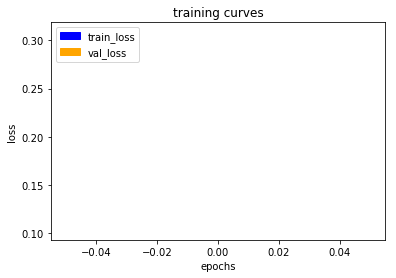

200/200 [==============================] - 141s - loss: 0.3077 - val_loss: 0.1036
Epoch 2/100
199/200 [============================>.] - ETA: 0s - loss: 0.0521

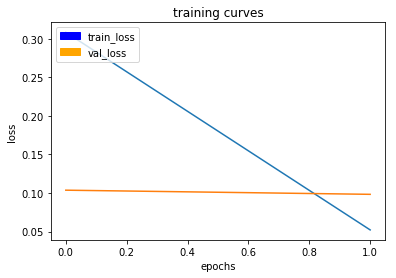

200/200 [==============================] - 120s - loss: 0.0521 - val_loss: 0.0982
Epoch 3/100
199/200 [============================>.] - ETA: 0s - loss: 0.0426

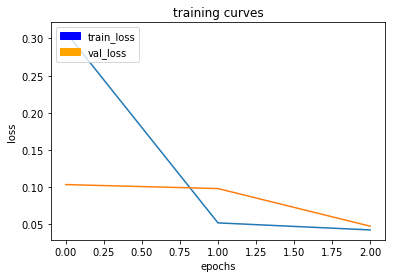

200/200 [==============================] - 120s - loss: 0.0426 - val_loss: 0.0477
Epoch 4/100
199/200 [============================>.] - ETA: 0s - loss: 0.0385

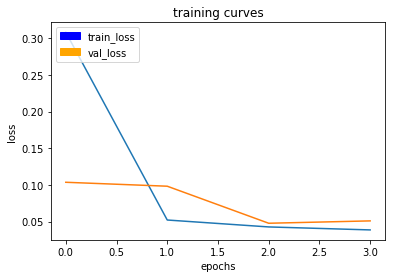

200/200 [==============================] - 120s - loss: 0.0386 - val_loss: 0.0509
Epoch 5/100
199/200 [============================>.] - ETA: 0s - loss: 0.0354

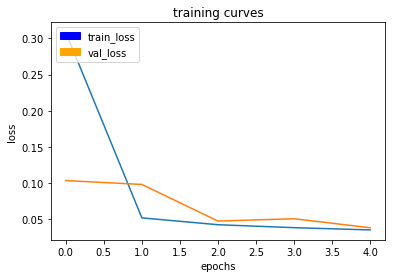

200/200 [==============================] - 120s - loss: 0.0354 - val_loss: 0.0384
Epoch 6/100
199/200 [============================>.] - ETA: 0s - loss: 0.0331

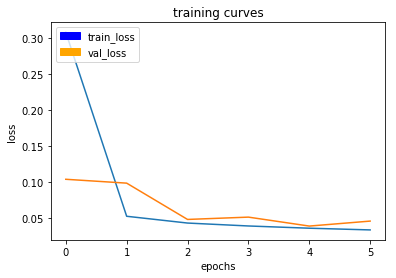

200/200 [==============================] - 120s - loss: 0.0331 - val_loss: 0.0454
Epoch 7/100
199/200 [============================>.] - ETA: 0s - loss: 0.0324

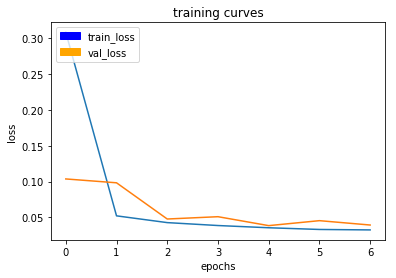

200/200 [==============================] - 120s - loss: 0.0324 - val_loss: 0.0393
Epoch 8/100
199/200 [============================>.] - ETA: 0s - loss: 0.0309

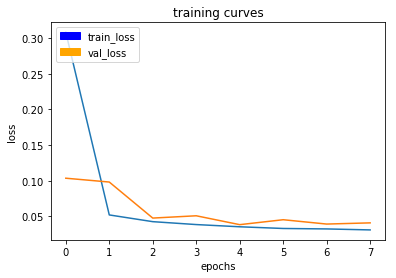

200/200 [==============================] - 120s - loss: 0.0310 - val_loss: 0.0409
Epoch 9/100
199/200 [============================>.] - ETA: 0s - loss: 0.0300

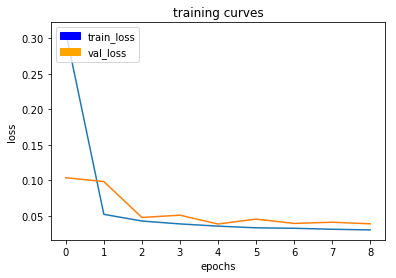

200/200 [==============================] - 120s - loss: 0.0301 - val_loss: 0.0387
Epoch 10/100
199/200 [============================>.] - ETA: 0s - loss: 0.0293

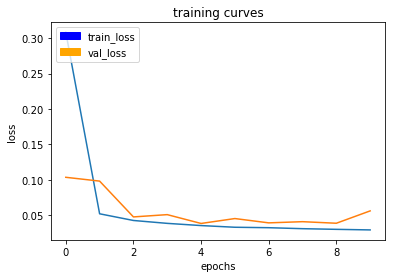

200/200 [==============================] - 120s - loss: 0.0293 - val_loss: 0.0562
Epoch 11/100
199/200 [============================>.] - ETA: 0s - loss: 0.0289

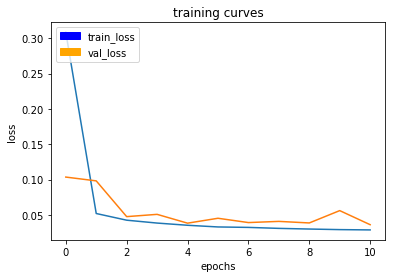

200/200 [==============================] - 120s - loss: 0.0289 - val_loss: 0.0363
Epoch 12/100
199/200 [============================>.] - ETA: 0s - loss: 0.0274

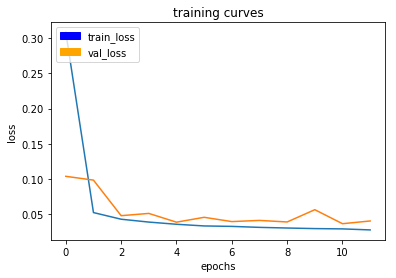

200/200 [==============================] - 120s - loss: 0.0274 - val_loss: 0.0401
Epoch 13/100
199/200 [============================>.] - ETA: 0s - loss: 0.0281

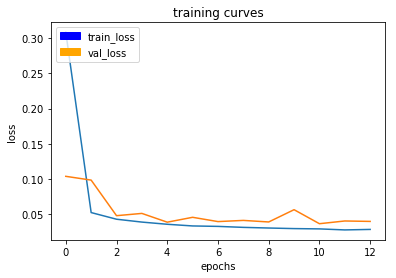

200/200 [==============================] - 120s - loss: 0.0281 - val_loss: 0.0395
Epoch 14/100
199/200 [============================>.] - ETA: 0s - loss: 0.0273

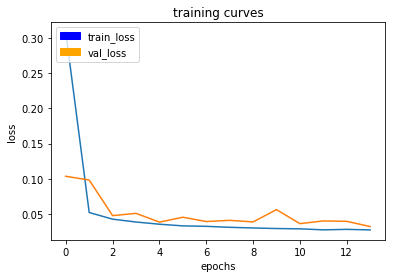

200/200 [==============================] - 121s - loss: 0.0273 - val_loss: 0.0321
Epoch 15/100
199/200 [============================>.] - ETA: 0s - loss: 0.0268

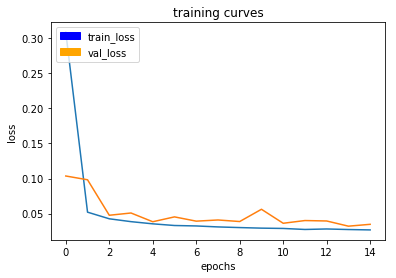

200/200 [==============================] - 120s - loss: 0.0268 - val_loss: 0.0348
Epoch 16/100
199/200 [============================>.] - ETA: 0s - loss: 0.0263

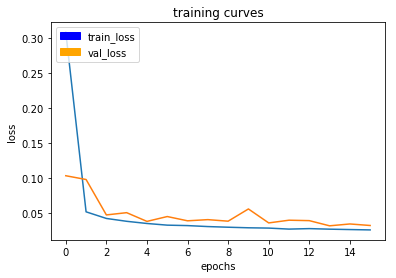

200/200 [==============================] - 120s - loss: 0.0263 - val_loss: 0.0326
Epoch 17/100
199/200 [============================>.] - ETA: 0s - loss: 0.0259

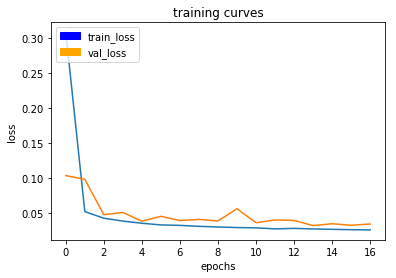

200/200 [==============================] - 121s - loss: 0.0259 - val_loss: 0.0344
Epoch 18/100
199/200 [============================>.] - ETA: 0s - loss: 0.0253

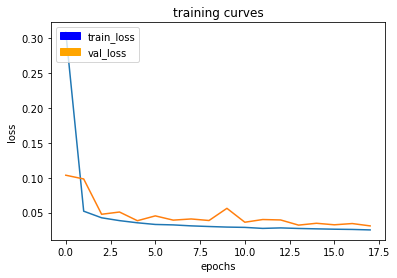

200/200 [==============================] - 121s - loss: 0.0252 - val_loss: 0.0310
Epoch 19/100
199/200 [============================>.] - ETA: 0s - loss: 0.0254

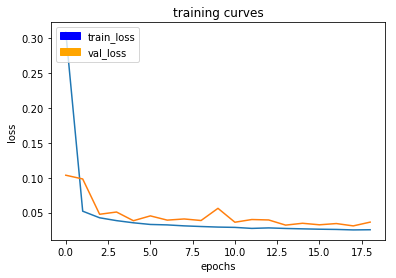

200/200 [==============================] - 121s - loss: 0.0255 - val_loss: 0.0364
Epoch 20/100
199/200 [============================>.] - ETA: 0s - loss: 0.0247

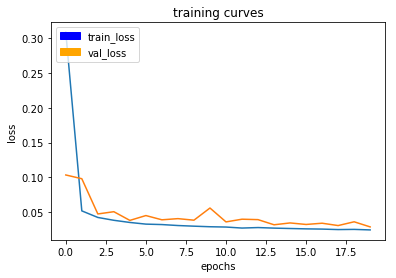

200/200 [==============================] - 120s - loss: 0.0247 - val_loss: 0.0291
Epoch 21/100
199/200 [============================>.] - ETA: 0s - loss: 0.0248

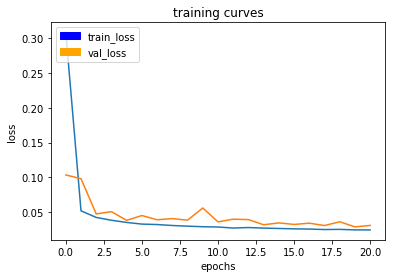

200/200 [==============================] - 120s - loss: 0.0248 - val_loss: 0.0312
Epoch 22/100
199/200 [============================>.] - ETA: 0s - loss: 0.0237

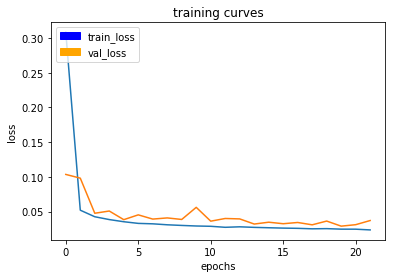

200/200 [==============================] - 120s - loss: 0.0237 - val_loss: 0.0372
Epoch 23/100
199/200 [============================>.] - ETA: 0s - loss: 0.0239

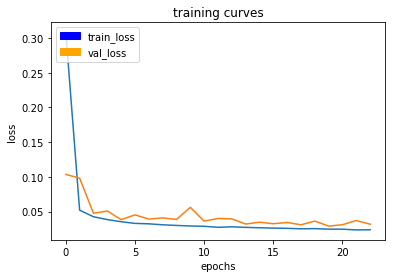

200/200 [==============================] - 120s - loss: 0.0239 - val_loss: 0.0319
Epoch 24/100
199/200 [============================>.] - ETA: 0s - loss: 0.0240

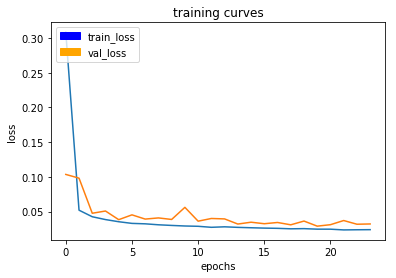

200/200 [==============================] - 121s - loss: 0.0240 - val_loss: 0.0322
Epoch 25/100
199/200 [============================>.] - ETA: 0s - loss: 0.0231

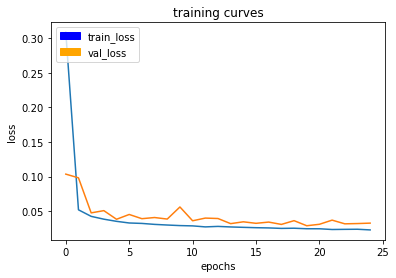

200/200 [==============================] - 119s - loss: 0.0231 - val_loss: 0.0329
Epoch 26/100
199/200 [============================>.] - ETA: 0s - loss: 0.0239

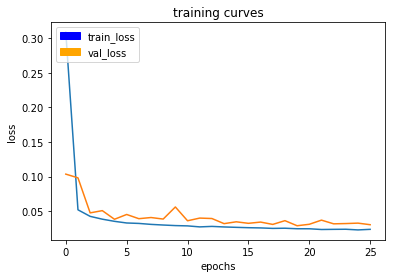

200/200 [==============================] - 120s - loss: 0.0239 - val_loss: 0.0306
Epoch 27/100
199/200 [============================>.] - ETA: 0s - loss: 0.0227

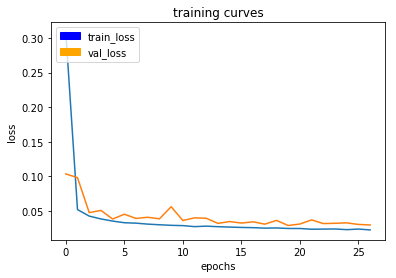

200/200 [==============================] - 120s - loss: 0.0227 - val_loss: 0.0299
Epoch 28/100
199/200 [============================>.] - ETA: 0s - loss: 0.0228

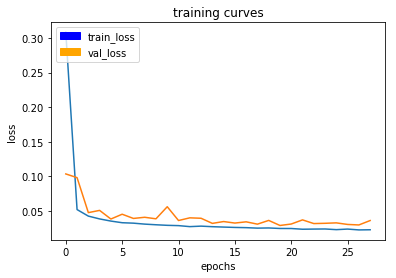

200/200 [==============================] - 120s - loss: 0.0229 - val_loss: 0.0362
Epoch 29/100
199/200 [============================>.] - ETA: 0s - loss: 0.0228

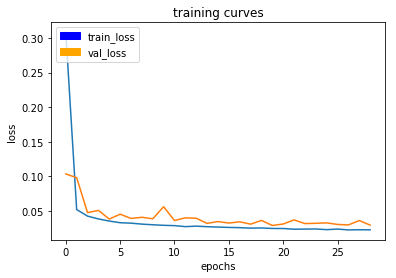

200/200 [==============================] - 120s - loss: 0.0228 - val_loss: 0.0296
Epoch 30/100
199/200 [============================>.] - ETA: 0s - loss: 0.0226

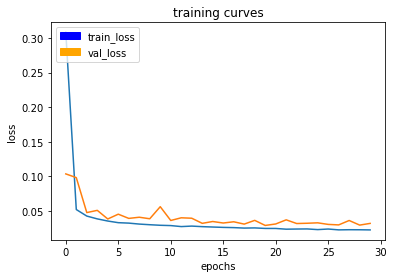

200/200 [==============================] - 120s - loss: 0.0226 - val_loss: 0.0320
Epoch 31/100
199/200 [============================>.] - ETA: 0s - loss: 0.0228

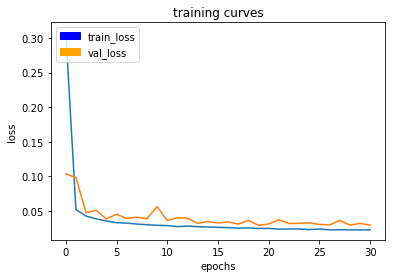

200/200 [==============================] - 120s - loss: 0.0227 - val_loss: 0.0296
Epoch 32/100
199/200 [============================>.] - ETA: 0s - loss: 0.0223

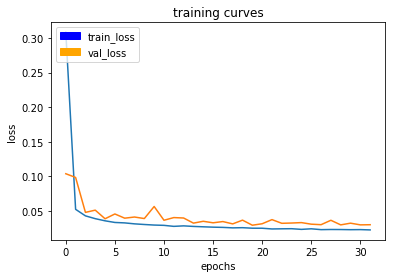

200/200 [==============================] - 120s - loss: 0.0223 - val_loss: 0.0298
Epoch 33/100
199/200 [============================>.] - ETA: 0s - loss: 0.0219

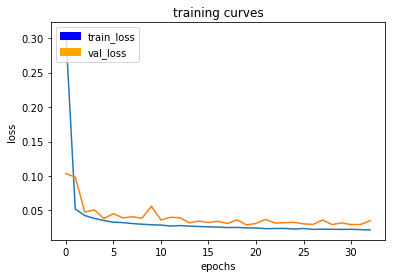

200/200 [==============================] - 120s - loss: 0.0218 - val_loss: 0.0352
Epoch 34/100
199/200 [============================>.] - ETA: 0s - loss: 0.0229

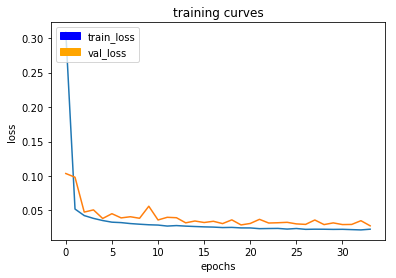

200/200 [==============================] - 119s - loss: 0.0229 - val_loss: 0.0278
Epoch 35/100
199/200 [============================>.] - ETA: 0s - loss: 0.0215

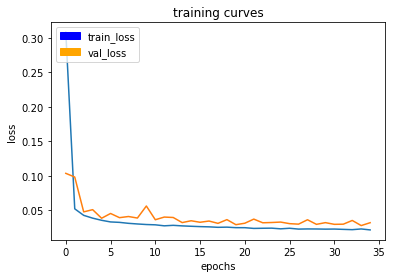

200/200 [==============================] - 120s - loss: 0.0215 - val_loss: 0.0319
Epoch 36/100
199/200 [============================>.] - ETA: 0s - loss: 0.0221

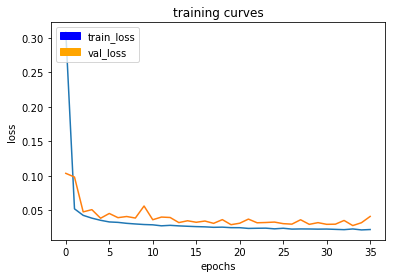

200/200 [==============================] - 121s - loss: 0.0220 - val_loss: 0.0410
Epoch 37/100
199/200 [============================>.] - ETA: 0s - loss: 0.0213

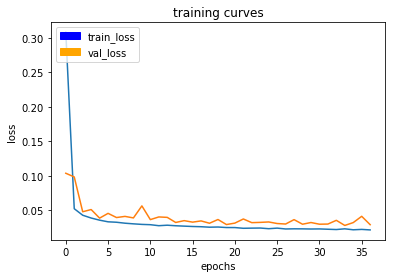

200/200 [==============================] - 119s - loss: 0.0213 - val_loss: 0.0289
Epoch 38/100
199/200 [============================>.] - ETA: 0s - loss: 0.0214

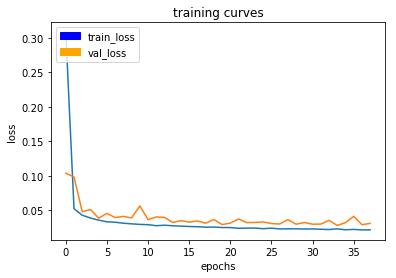

200/200 [==============================] - 120s - loss: 0.0214 - val_loss: 0.0307
Epoch 39/100
199/200 [============================>.] - ETA: 0s - loss: 0.0214

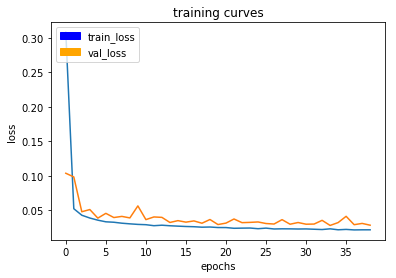

200/200 [==============================] - 121s - loss: 0.0214 - val_loss: 0.0281
Epoch 40/100
199/200 [============================>.] - ETA: 0s - loss: 0.0212

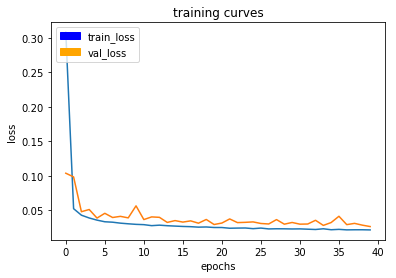

200/200 [==============================] - 120s - loss: 0.0212 - val_loss: 0.0261
Epoch 41/100
199/200 [============================>.] - ETA: 0s - loss: 0.0220

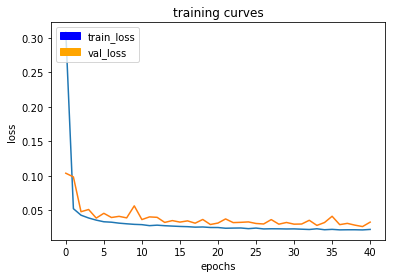

200/200 [==============================] - 121s - loss: 0.0219 - val_loss: 0.0325
Epoch 42/100
199/200 [============================>.] - ETA: 0s - loss: 0.0200

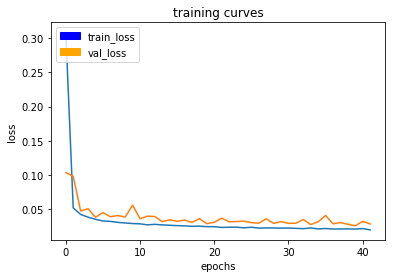

200/200 [==============================] - 119s - loss: 0.0200 - val_loss: 0.0287
Epoch 43/100
199/200 [============================>.] - ETA: 0s - loss: 0.0205

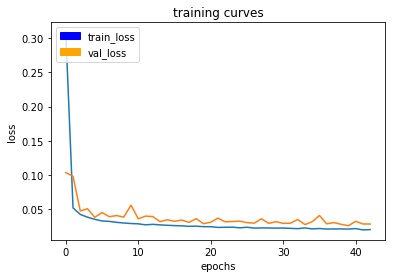

200/200 [==============================] - 120s - loss: 0.0205 - val_loss: 0.0286
Epoch 44/100
199/200 [============================>.] - ETA: 0s - loss: 0.0216

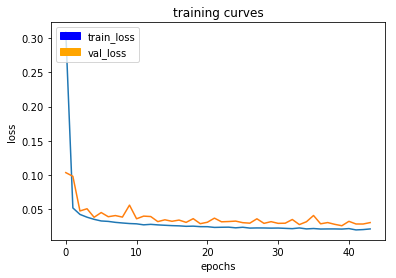

200/200 [==============================] - 119s - loss: 0.0215 - val_loss: 0.0307
Epoch 45/100
199/200 [============================>.] - ETA: 0s - loss: 0.0206

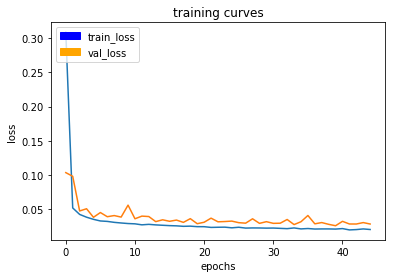

200/200 [==============================] - 119s - loss: 0.0206 - val_loss: 0.0286
Epoch 46/100
199/200 [============================>.] - ETA: 0s - loss: 0.0202

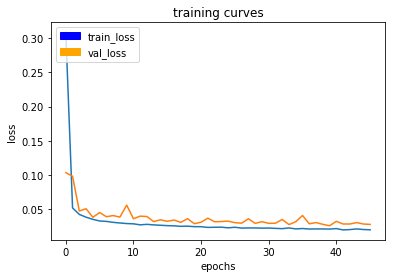

200/200 [==============================] - 120s - loss: 0.0202 - val_loss: 0.0280
Epoch 47/100
199/200 [============================>.] - ETA: 0s - loss: 0.0206

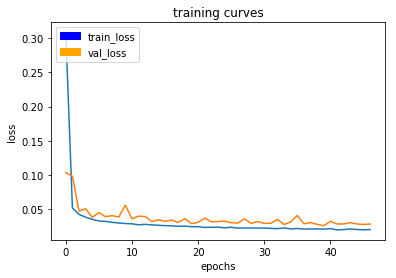

200/200 [==============================] - 120s - loss: 0.0206 - val_loss: 0.0285
Epoch 48/100
199/200 [============================>.] - ETA: 0s - loss: 0.0206

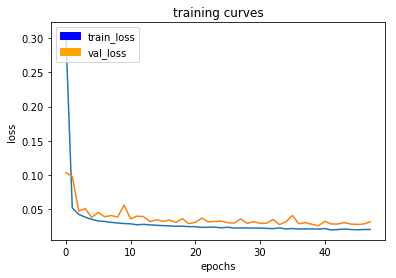

200/200 [==============================] - 120s - loss: 0.0207 - val_loss: 0.0318
Epoch 49/100
199/200 [============================>.] - ETA: 0s - loss: 0.0204

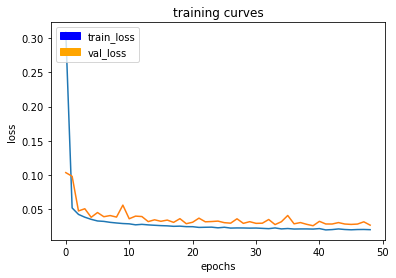

200/200 [==============================] - 120s - loss: 0.0204 - val_loss: 0.0270
Epoch 50/100
199/200 [============================>.] - ETA: 0s - loss: 0.0206

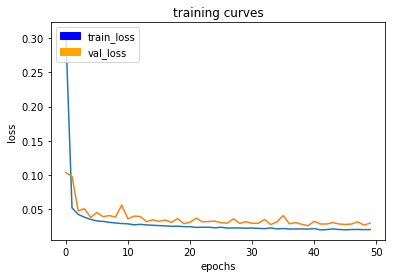

200/200 [==============================] - 121s - loss: 0.0206 - val_loss: 0.0299
Epoch 51/100
199/200 [============================>.] - ETA: 0s - loss: 0.0196

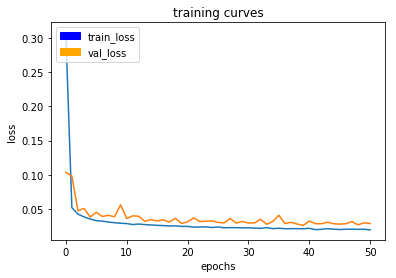

200/200 [==============================] - 120s - loss: 0.0196 - val_loss: 0.0289
Epoch 52/100
199/200 [============================>.] - ETA: 0s - loss: 0.0196

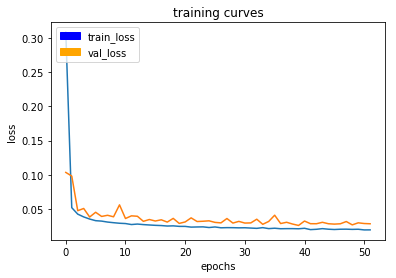

200/200 [==============================] - 120s - loss: 0.0196 - val_loss: 0.0286
Epoch 53/100
199/200 [============================>.] - ETA: 0s - loss: 0.0203

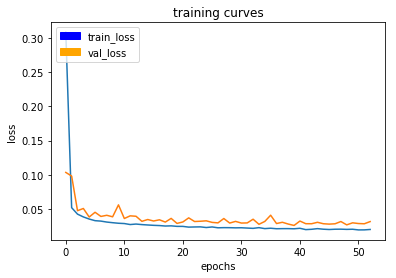

200/200 [==============================] - 120s - loss: 0.0202 - val_loss: 0.0317
Epoch 54/100
199/200 [============================>.] - ETA: 0s - loss: 0.0196

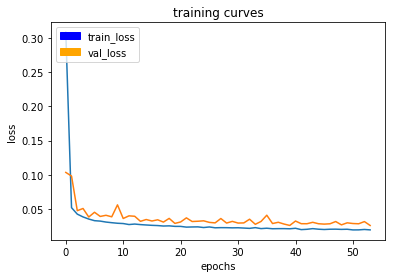

200/200 [==============================] - 120s - loss: 0.0196 - val_loss: 0.0261
Epoch 55/100
199/200 [============================>.] - ETA: 0s - loss: 0.0201

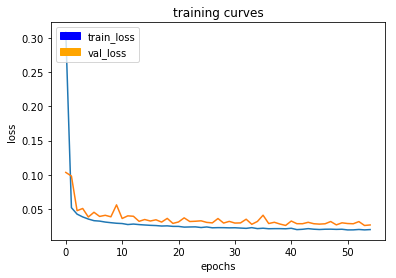

200/200 [==============================] - 120s - loss: 0.0201 - val_loss: 0.0268
Epoch 56/100
199/200 [============================>.] - ETA: 0s - loss: 0.0200

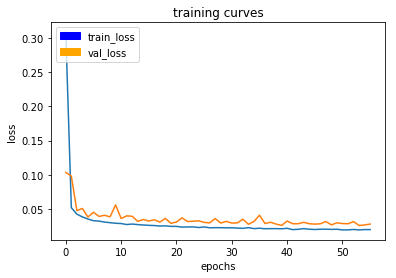

200/200 [==============================] - 120s - loss: 0.0200 - val_loss: 0.0281
Epoch 57/100
199/200 [============================>.] - ETA: 0s - loss: 0.0199

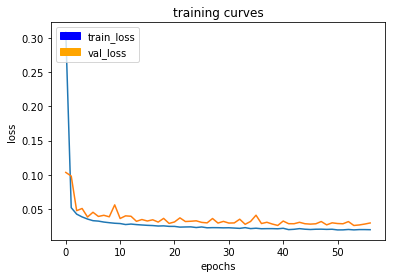

200/200 [==============================] - 121s - loss: 0.0199 - val_loss: 0.0297
Epoch 58/100
199/200 [============================>.] - ETA: 0s - loss: 0.0194

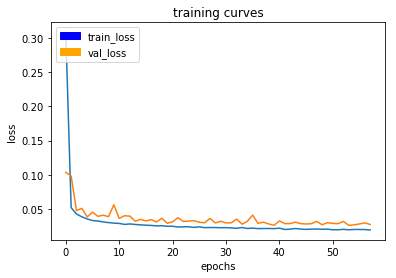

200/200 [==============================] - 120s - loss: 0.0194 - val_loss: 0.0273
Epoch 59/100
199/200 [============================>.] - ETA: 0s - loss: 0.0195

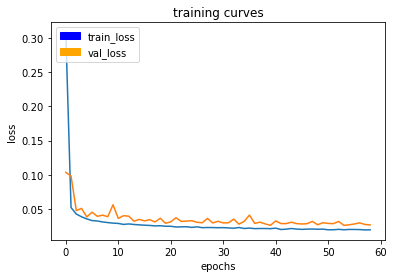

200/200 [==============================] - 120s - loss: 0.0195 - val_loss: 0.0267
Epoch 60/100
199/200 [============================>.] - ETA: 0s - loss: 0.0196

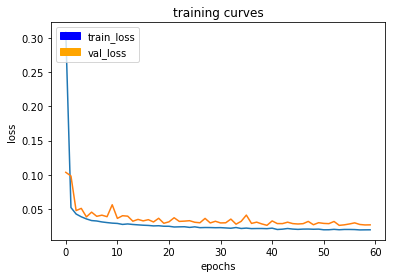

200/200 [==============================] - 120s - loss: 0.0195 - val_loss: 0.0268
Epoch 61/100
199/200 [============================>.] - ETA: 0s - loss: 0.0193

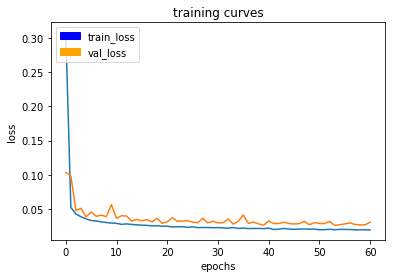

200/200 [==============================] - 120s - loss: 0.0193 - val_loss: 0.0306
Epoch 62/100
199/200 [============================>.] - ETA: 0s - loss: 0.0195

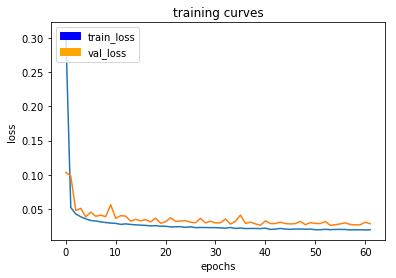

200/200 [==============================] - 119s - loss: 0.0195 - val_loss: 0.0283
Epoch 63/100
199/200 [============================>.] - ETA: 0s - loss: 0.0189

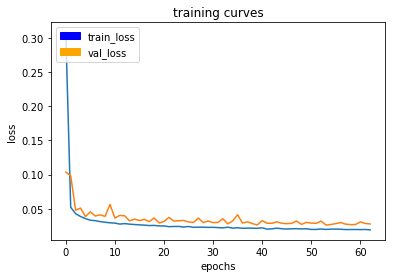

200/200 [==============================] - 120s - loss: 0.0189 - val_loss: 0.0276
Epoch 64/100
199/200 [============================>.] - ETA: 0s - loss: 0.0194

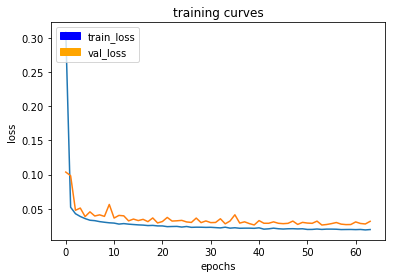

200/200 [==============================] - 120s - loss: 0.0194 - val_loss: 0.0315
Epoch 65/100
199/200 [============================>.] - ETA: 0s - loss: 0.0191

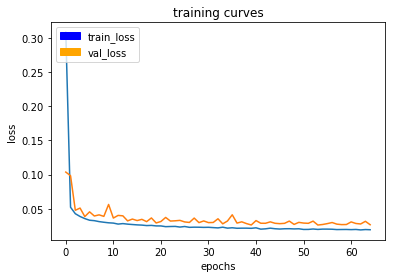

200/200 [==============================] - 119s - loss: 0.0191 - val_loss: 0.0265
Epoch 66/100
199/200 [============================>.] - ETA: 0s - loss: 0.0189

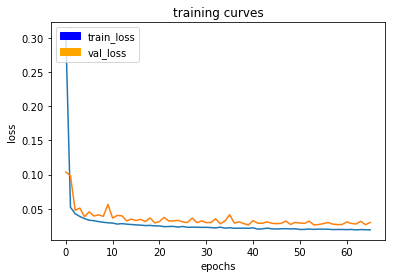

200/200 [==============================] - 120s - loss: 0.0189 - val_loss: 0.0298
Epoch 67/100
199/200 [============================>.] - ETA: 0s - loss: 0.0189

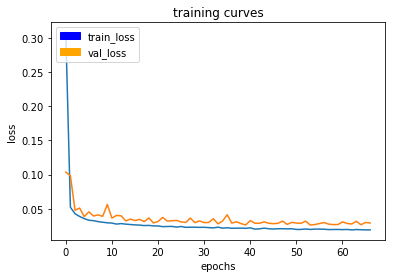

200/200 [==============================] - 120s - loss: 0.0189 - val_loss: 0.0290
Epoch 68/100
199/200 [============================>.] - ETA: 0s - loss: 0.0198

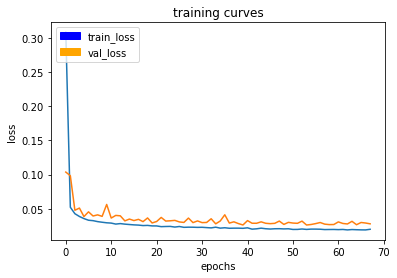

200/200 [==============================] - 120s - loss: 0.0198 - val_loss: 0.0278
Epoch 69/100
199/200 [============================>.] - ETA: 0s - loss: 0.0189

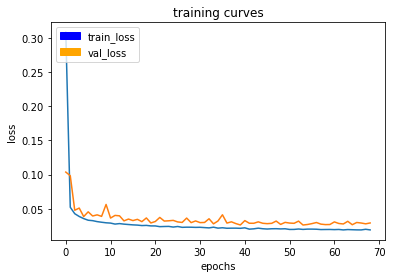

200/200 [==============================] - 120s - loss: 0.0189 - val_loss: 0.0291
Epoch 70/100
199/200 [============================>.] - ETA: 0s - loss: 0.0190

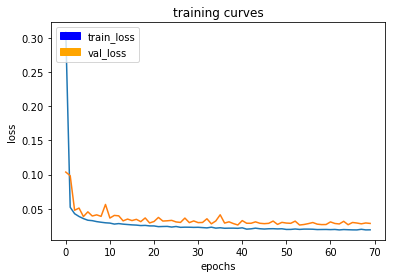

200/200 [==============================] - 120s - loss: 0.0190 - val_loss: 0.0284
Epoch 71/100
199/200 [============================>.] - ETA: 0s - loss: 0.0189

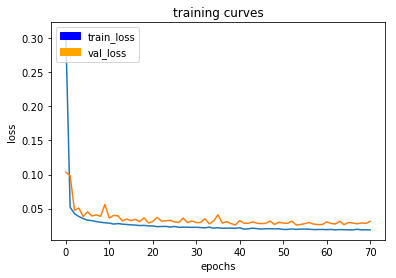

200/200 [==============================] - 120s - loss: 0.0189 - val_loss: 0.0313
Epoch 72/100
199/200 [============================>.] - ETA: 0s - loss: 0.0191

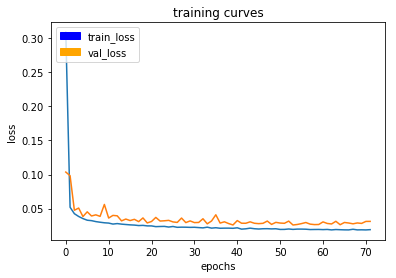

200/200 [==============================] - 120s - loss: 0.0192 - val_loss: 0.0314
Epoch 73/100
199/200 [============================>.] - ETA: 0s - loss: 0.0188

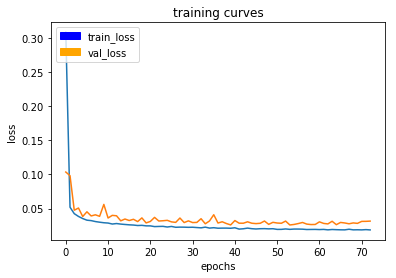

200/200 [==============================] - 120s - loss: 0.0188 - val_loss: 0.0317
Epoch 74/100
199/200 [============================>.] - ETA: 0s - loss: 0.0193

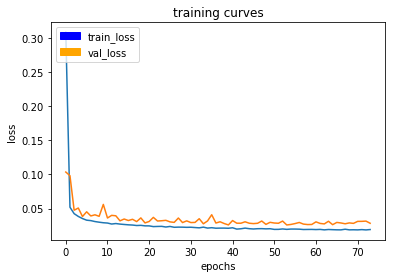

200/200 [==============================] - 120s - loss: 0.0193 - val_loss: 0.0285
Epoch 75/100
199/200 [============================>.] - ETA: 0s - loss: 0.0189

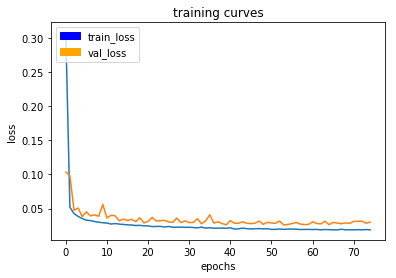

200/200 [==============================] - 120s - loss: 0.0188 - val_loss: 0.0303
Epoch 76/100
199/200 [============================>.] - ETA: 0s - loss: 0.0183

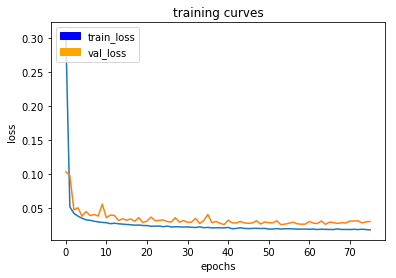

200/200 [==============================] - 120s - loss: 0.0183 - val_loss: 0.0307
Epoch 77/100
199/200 [============================>.] - ETA: 0s - loss: 0.0189

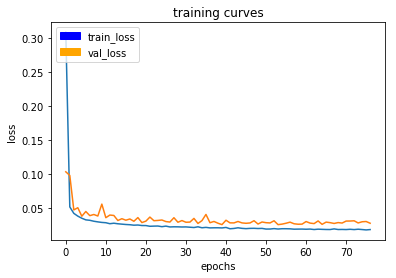

200/200 [==============================] - 120s - loss: 0.0189 - val_loss: 0.0281
Epoch 78/100
199/200 [============================>.] - ETA: 0s - loss: 0.0185

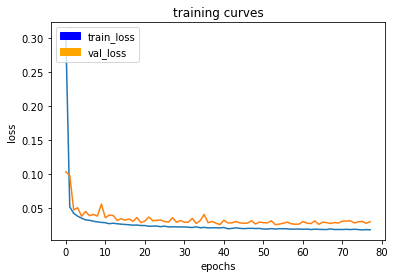

200/200 [==============================] - 120s - loss: 0.0185 - val_loss: 0.0303
Epoch 79/100
199/200 [============================>.] - ETA: 0s - loss: 0.0195

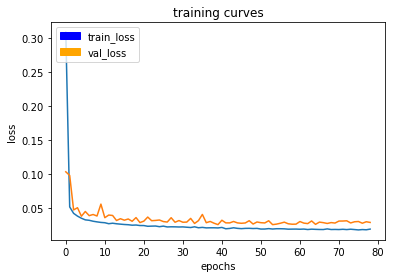

200/200 [==============================] - 120s - loss: 0.0195 - val_loss: 0.0293
Epoch 80/100
199/200 [============================>.] - ETA: 0s - loss: 0.0185

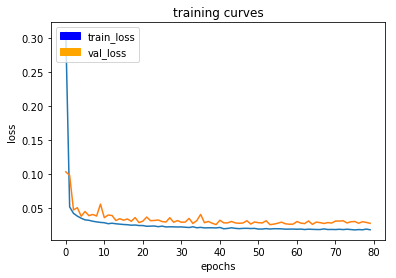

200/200 [==============================] - 120s - loss: 0.0185 - val_loss: 0.0280
Epoch 81/100
199/200 [============================>.] - ETA: 0s - loss: 0.0188

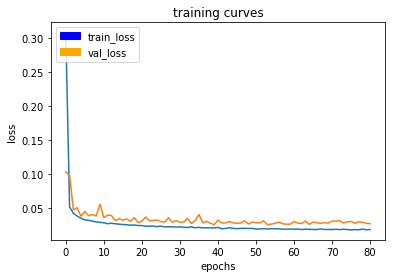

200/200 [==============================] - 120s - loss: 0.0188 - val_loss: 0.0276
Epoch 82/100
199/200 [============================>.] - ETA: 0s - loss: 0.0181

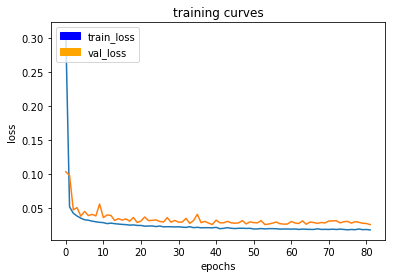

200/200 [==============================] - 120s - loss: 0.0182 - val_loss: 0.0260
Epoch 83/100
199/200 [============================>.] - ETA: 0s - loss: 0.0183

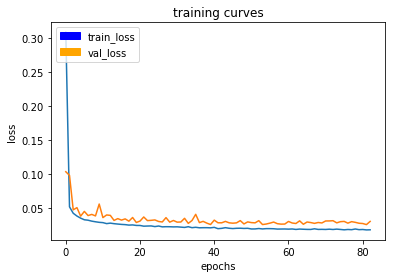

200/200 [==============================] - 120s - loss: 0.0183 - val_loss: 0.0307
Epoch 84/100
199/200 [============================>.] - ETA: 0s - loss: 0.0181

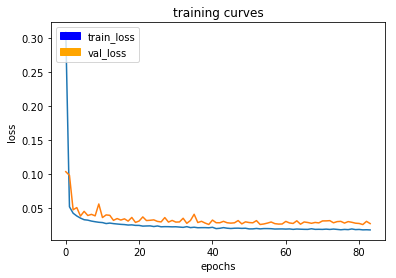

200/200 [==============================] - 120s - loss: 0.0181 - val_loss: 0.0274
Epoch 85/100
199/200 [============================>.] - ETA: 0s - loss: 0.0188

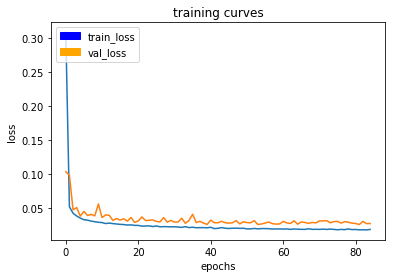

200/200 [==============================] - 120s - loss: 0.0188 - val_loss: 0.0275
Epoch 86/100
199/200 [============================>.] - ETA: 0s - loss: 0.0186

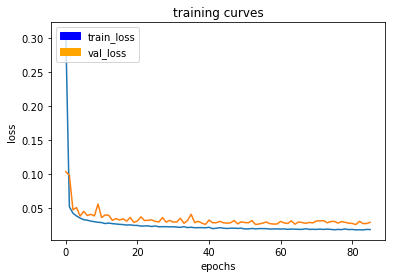

200/200 [==============================] - 120s - loss: 0.0186 - val_loss: 0.0292
Epoch 87/100
199/200 [============================>.] - ETA: 0s - loss: 0.0182

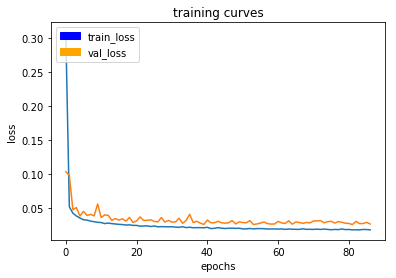

200/200 [==============================] - 120s - loss: 0.0182 - val_loss: 0.0268
Epoch 88/100
199/200 [============================>.] - ETA: 0s - loss: 0.0181

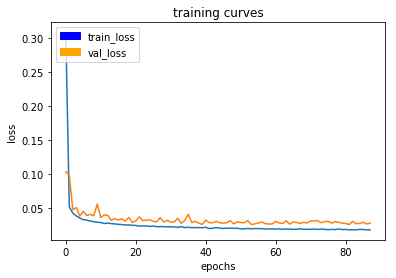

200/200 [==============================] - 120s - loss: 0.0181 - val_loss: 0.0279
Epoch 89/100
199/200 [============================>.] - ETA: 0s - loss: 0.0180

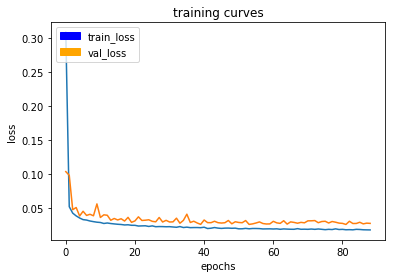

200/200 [==============================] - 120s - loss: 0.0180 - val_loss: 0.0276
Epoch 90/100
199/200 [============================>.] - ETA: 0s - loss: 0.0183

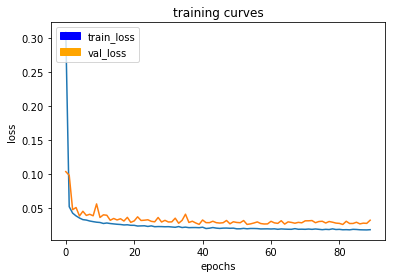

200/200 [==============================] - 120s - loss: 0.0183 - val_loss: 0.0322
Epoch 91/100
199/200 [============================>.] - ETA: 0s - loss: 0.0180

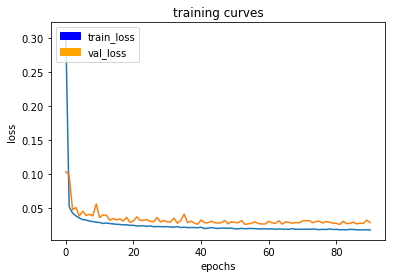

200/200 [==============================] - 120s - loss: 0.0180 - val_loss: 0.0289
Epoch 92/100
199/200 [============================>.] - ETA: 0s - loss: 0.0188

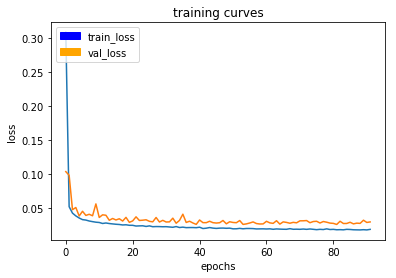

200/200 [==============================] - 120s - loss: 0.0188 - val_loss: 0.0297
Epoch 93/100
199/200 [============================>.] - ETA: 0s - loss: 0.0181

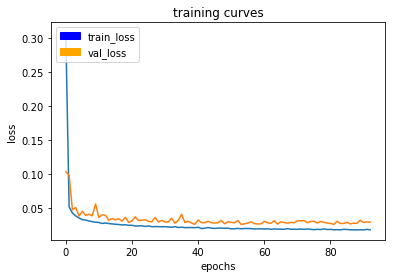

200/200 [==============================] - 119s - loss: 0.0181 - val_loss: 0.0293
Epoch 94/100
199/200 [============================>.] - ETA: 0s - loss: 0.0179

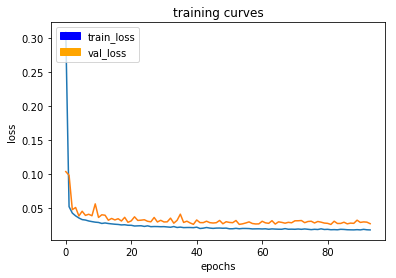

200/200 [==============================] - 120s - loss: 0.0179 - val_loss: 0.0271
Epoch 95/100
199/200 [============================>.] - ETA: 0s - loss: 0.0179

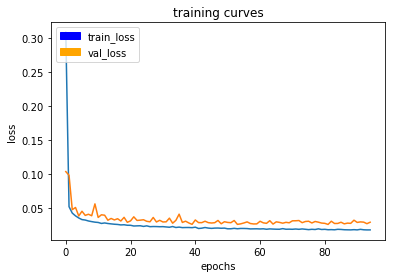

200/200 [==============================] - 121s - loss: 0.0179 - val_loss: 0.0292
Epoch 96/100
199/200 [============================>.] - ETA: 0s - loss: 0.0181

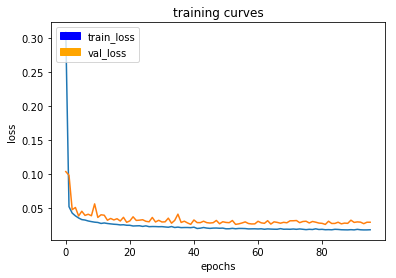

200/200 [==============================] - 120s - loss: 0.0181 - val_loss: 0.0292
Epoch 97/100
199/200 [============================>.] - ETA: 0s - loss: 0.0177

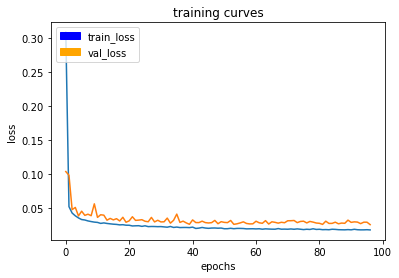

200/200 [==============================] - 120s - loss: 0.0179 - val_loss: 0.0256
Epoch 98/100
199/200 [============================>.] - ETA: 0s - loss: 0.0177

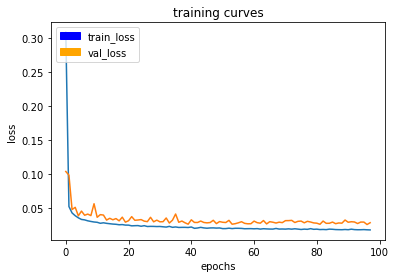

200/200 [==============================] - 120s - loss: 0.0177 - val_loss: 0.0283
Epoch 99/100
199/200 [============================>.] - ETA: 0s - loss: 0.0187

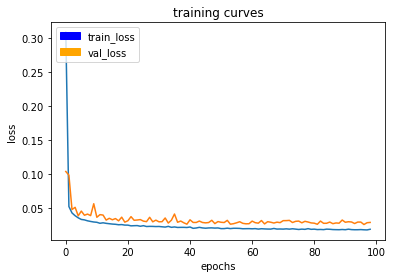

200/200 [==============================] - 120s - loss: 0.0187 - val_loss: 0.0287
Epoch 100/100
199/200 [============================>.] - ETA: 0s - loss: 0.0181

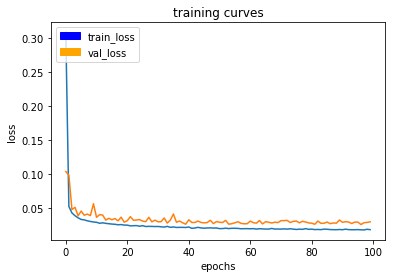

200/200 [==============================] - 121s - loss: 0.0181 - val_loss: 0.0296


In [18]:
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

plot_model(model, to_file='model.png')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train_combined'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [19]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [20]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [21]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

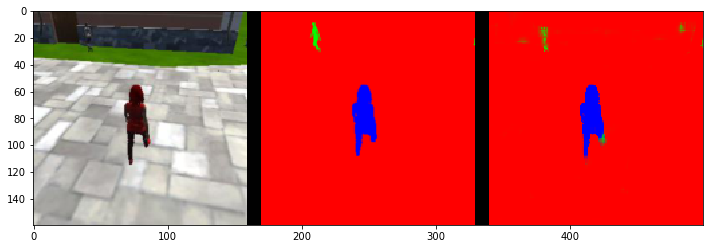

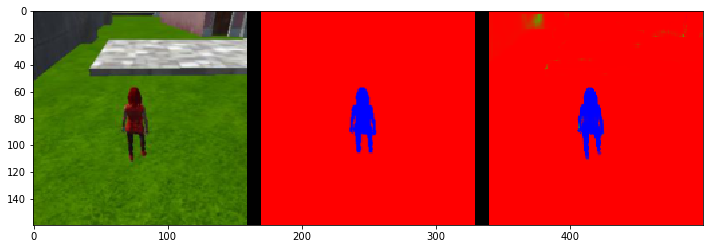

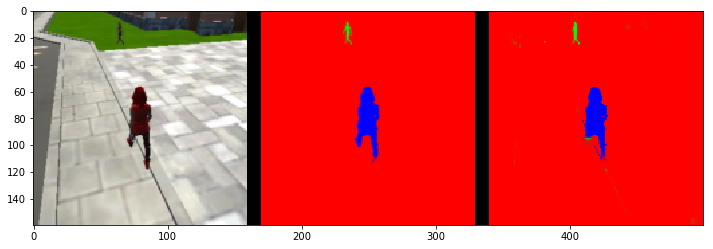

In [22]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

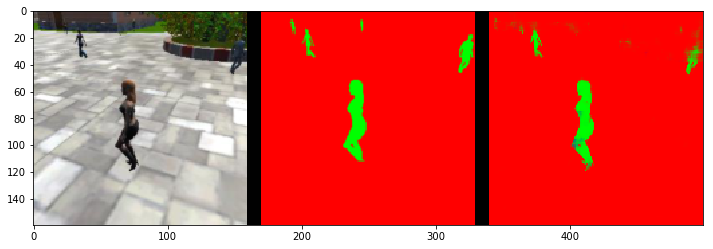

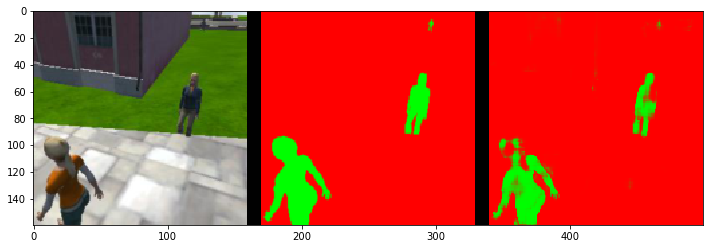

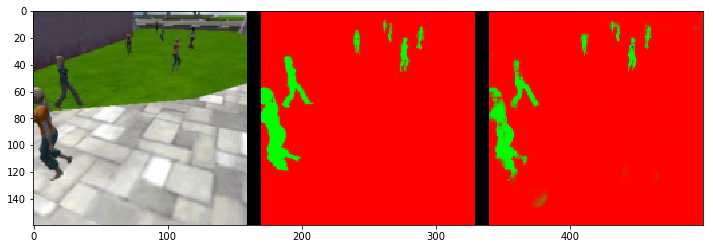

In [23]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

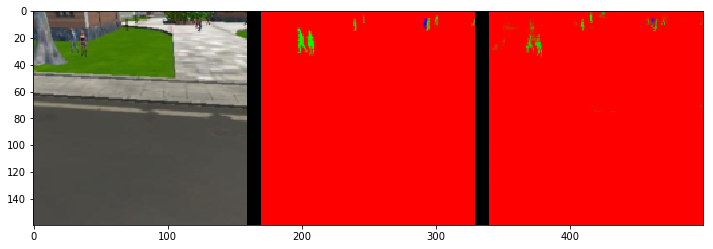

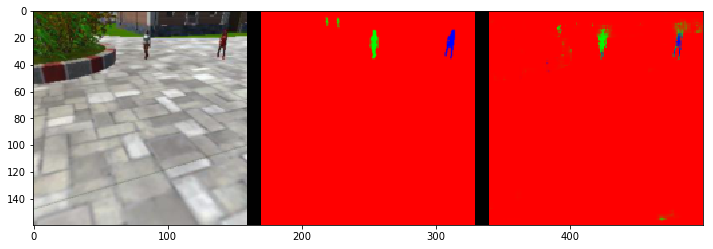

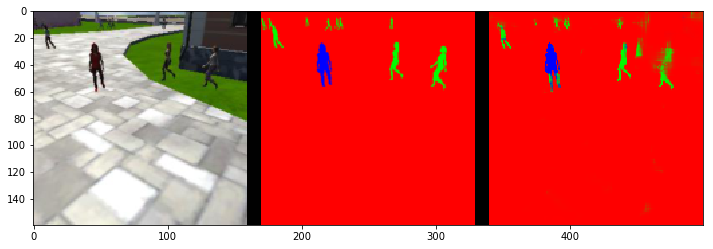

In [24]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [25]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9949616739180054
average intersection over union for other people is 0.33668158912846513
average intersection over union for the hero is 0.9117608548633593
number true positives: 539, number false positives: 0, number false negatives: 0


In [26]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.983962860855679
average intersection over union for other people is 0.6763629059885953
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 103, number false negatives: 0


In [27]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9959159740398693
average intersection over union for other people is 0.4265099793670254
average intersection over union for the hero is 0.2655411390865785
number true positives: 167, number false positives: 3, number false negatives: 134


In [28]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7463002114164905


In [29]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.588650996975


In [30]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.439310363493
